<a href="https://colab.research.google.com/github/Gunjan712Sehrawat/titanic_kmeans_pca/blob/main/titanic_kmeans_pca.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Titanic - Unsupervised: KMeans + PCA
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
import joblib
np.random.seed(42)


In [ ]:
df = sns.load_dataset('titanic')   # simple and fast for experiments
df.shape, df.head(3)


((891, 15),
    survived  pclass     sex   age  sibsp  parch     fare embarked  class  \
 0         0       3    male  22.0      1      0   7.2500        S  Third   
 1         1       1  female  38.0      1      0  71.2833        C  First   
 2         1       3  female  26.0      0      0   7.9250        S  Third   
 
      who  adult_male deck  embark_town alive  alone  
 0    man        True  NaN  Southampton    no  False  
 1  woman       False    C    Cherbourg   yes  False  
 2  woman       False  NaN  Southampton   yes   True  )

In [ ]:
# Columns commonly available in both seaborn and Kaggle variants:
# pclass, sex, age, sibsp, parch, fare, embarked, survived (survived may exist)
df.info()
# select features to use for clustering
features = ['pclass','sex','age','sibsp','parch','fare','embarked']
X = df[features].copy()
y = df['survived'] if 'survived' in df.columns else None
X.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


,pclass,sex,age,sibsp,parch,fare,embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S


In [ ]:
num_features = ['age','sibsp','parch','fare','pclass']   # treat pclass as numeric (okay)
cat_features = ['sex','embarked']

num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])


preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_features),
    ('cat', cat_transformer, cat_features)
])

X_prep = preprocessor.fit_transform(X)
print("Prepared feature matrix shape:", X_prep.shape)


Prepared feature matrix shape: (891, 10)


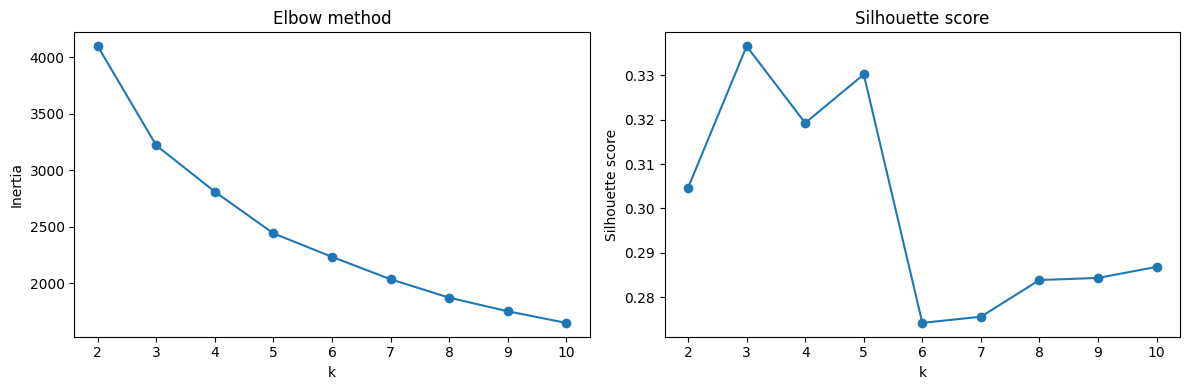

In [ ]:
inertia = []
sil_scores = []
K_range = range(2,11)

for k in K_range:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = km.fit_predict(X_prep)
    inertia.append(km.inertia_)
    sil_scores.append(silhouette_score(X_prep, labels))

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(list(K_range), inertia, '-o')
plt.xlabel('k'); plt.ylabel('Inertia'); plt.title('Elbow method')

plt.subplot(1,2,2)
plt.plot(list(K_range), sil_scores, '-o')
plt.xlabel('k'); plt.ylabel('Silhouette score'); plt.title('Silhouette score')
plt.tight_layout()
plt.show()


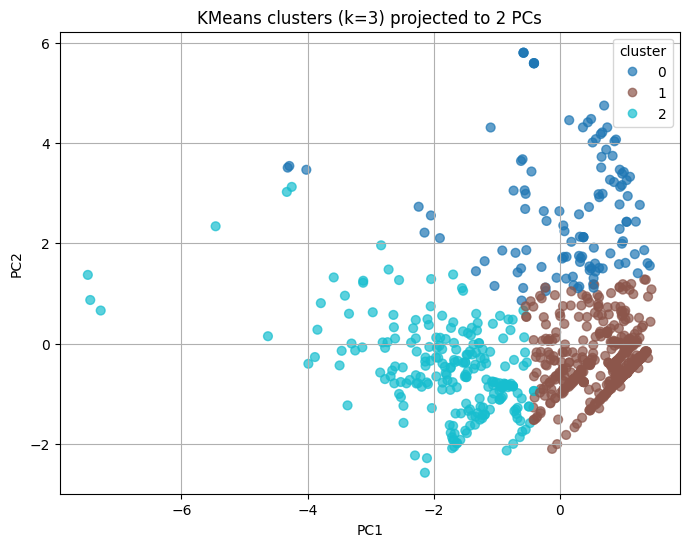

<Figure size 640x480 with 0 Axes>

In [ ]:
k_chosen = 3   # <-- change after inspecting elbow/silhouette
km = KMeans(n_clusters=k_chosen, n_init=10, random_state=42)
cluster_labels = km.fit_predict(X_prep)

# PCA to 2D for plotting
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_prep)

plt.figure(figsize=(8,6))
sc = plt.scatter(X_pca[:,0], X_pca[:,1], c=cluster_labels, cmap='tab10', alpha=0.7, s=40)
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.title(f'KMeans clusters (k={k_chosen}) projected to 2 PCs')
plt.legend(*sc.legend_elements(), title="cluster")
plt.grid(True)
plt.show()

# Save figure
plt.savefig(f'kmeans_pca_k{k_chosen}.png', bbox_inches='tight')


In [ ]:
joblib.dump(km, 'kmeans_model.joblib')
joblib.dump(preprocessor, 'preprocessor.joblib')
joblib.dump(pca, 'pca_2d.joblib')
print("Saved model and preprocessing objects.")


Saved model and preprocessing objects.


In [ ]:
with open('RESULTS.md','w') as f:
    f.write("Titanic KMeans+PCA results\n")
    f.write(f"Chosen k: {k_chosen}\n")
    if y is not None:
        f.write(f"ARI: {adjusted_rand_score(y, cluster_labels):.4f}\n")
        f.write(f"NMI: {normalized_mutual_info_score(y, cluster_labels):.4f}\n")
print("Wrote RESULTS.md")


Wrote RESULTS.md
